### Trying to cluster bus by route, hours, day_of_week

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import glob

from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

### Prepare

In [21]:
df_routes_data = pd.read_csv("process-time.csv")

In [22]:
df_routes_data["sid1"] = df_routes_data["sid1"].astype(int)
df_routes_data["sid2"] = df_routes_data["sid2"].astype(int)

df_routes_data['ts1'] = pd.to_datetime(df_routes_data["ts1"])

def get_day_of_week(timestamp):
    return timestamp.day_name()
df_routes_data["day_of_week"] = df_routes_data["ts1"].apply(get_day_of_week)

df = df_routes_data.copy()

In [23]:
day_to_num = {
    "Monday": 1,
    "Tuesday": 2,
    "Wednesday": 3,
    "Thursday": 4,
    "Friday": 5,
    "Saturday": 6,
    "Sunday": 7,
}

# Map the values in the 'day_of_week' column using the defined mapping
df["day_of_week"] = df["day_of_week"].map(day_to_num)

def map_time_periods(hour):
    if 4 <= hour <= 8:
        return 0
    elif 8 <= hour <= 10:
        return 1
    elif 10 <= hour <= 12:
        return 0
    elif 12 <= hour <= 15:
        return 0
    elif 15 <= hour <= 20:
        return 1
    else:
        return 0

df['time_periods'] = df['hrs'].apply(map_time_periods)

df.sort_values(by=["day_of_week", "time_periods"], inplace=True)

df

,ts1,lat,lon,speed,direction,sid1,seq,vid,route_id,sid2,ts2,mins,hrs,day_of_week,time_periods
22205,2023-10-09 05:30:58,13.881417,100.458470,12,go,4151,4,16-5137 1,2-23,4142,2023-10-09 05:33:28,2.500000,5,1,0
22206,2023-10-09 08:41:57,13.881530,100.458357,8,go,4151,4,16-5137 1,2-23,4142,2023-10-09 08:44:57,3.000000,8,1,0
22207,2023-10-09 08:42:12,13.881261,100.458615,9,go,4151,4,16-5137 1,2-23,4142,2023-10-09 08:44:57,2.750000,8,1,0
22208,2023-10-09 05:33:28,13.874238,100.459473,29,go,4142,5,16-5137 1,2-23,2155,2023-10-09 05:34:14,0.766667,5,1,0
22209,2023-10-09 05:33:28,13.874238,100.459473,29,back,4142,70,16-5137 1,2-23,2155,2023-10-09 05:34:14,0.766667,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218311,2024-02-04 19:06:45,13.676583,100.462305,4,go,4699,3,13-1050 1,4-14,4642,2024-02-04 19:10:45,4.000000,19,7,1
218312,2024-02-04 19:06:45,13.676583,100.462305,4,go,4699,3,13-1050 1,4-14,4642,2024-02-04 19:10:45,4.000000,19,7,1
218313,2024-02-04 19:06:45,13.676583,100.462305,4,go,4699,3,13-1050 1,4-14,4642,2024-02-04 19:10:45,4.000000,19,7,1
218314,2024-02-04 19:06:45,13.676583,100.462305,4,go,4699,3,13-1050 1,4-14,4642,2024-02-04 19:10:45,4.000000,19,7,1


In [24]:
drop_cols = ["ts1", "ts2", "lat", "lon", "seq", "direction", "speed"]
df.drop(columns=drop_cols, inplace=True)
df

,sid1,vid,route_id,sid2,mins,hrs,day_of_week,time_periods
22205,4151,16-5137 1,2-23,4142,2.500000,5,1,0
22206,4151,16-5137 1,2-23,4142,3.000000,8,1,0
22207,4151,16-5137 1,2-23,4142,2.750000,8,1,0
22208,4142,16-5137 1,2-23,2155,0.766667,5,1,0
22209,4142,16-5137 1,2-23,2155,0.766667,5,1,0
...,...,...,...,...,...,...,...,...
218311,4699,13-1050 1,4-14,4642,4.000000,19,7,1
218312,4699,13-1050 1,4-14,4642,4.000000,19,7,1
218313,4699,13-1050 1,4-14,4642,4.000000,19,7,1
218314,4699,13-1050 1,4-14,4642,4.000000,19,7,1


"vid", "route_id" "day_of_week"


### Cluster


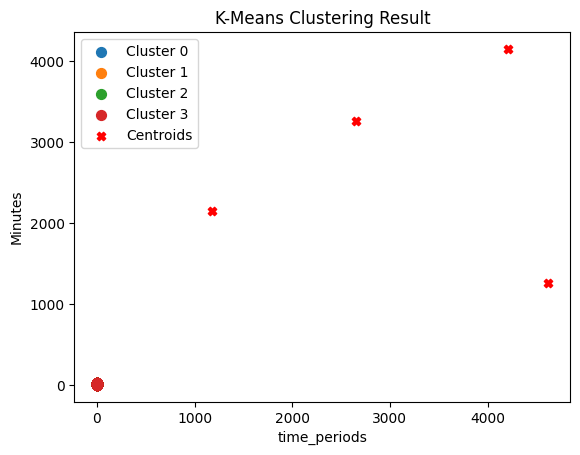

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()


columns_for_clustering = ['sid1', 'sid2', 'hrs'	,'day_of_week','time_periods']
X = df[columns_for_clustering]
# X["route_id"] = label_encoder.fit_transform(X["route_id"])

# Perform k-means clustering
num_clusters = 4  # Adjust this based on your needs
model = KMeans(n_clusters=num_clusters, random_state=42)
y_pred = model.fit_predict(X)

# Add the cluster labels to the DataFrame
df['cluster'] = y_pred
# Visualize the clustered data
for cluster_id in range(num_clusters):
    cluster_data = df[df['cluster'] == cluster_id]
    plt.scatter(cluster_data['time_periods'], cluster_data['mins'],
                label=f'Cluster {cluster_id}', s=50)

plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[
            :, 1], c='red', marker='X', label='Centroids')
plt.title('K-Means Clustering Result')
plt.xlabel('time_periods')
plt.ylabel('Minutes')
plt.legend()
plt.show()

In [72]:
df

,sid1,vid,route_id,sid2,mins,hrs,day_of_week,time_periods,cluster
59506,4202,16-1361 1,4-7E,4212,10.50,16,5,5,0
59507,4202,16-1361 1,4-7E,4212,10.50,16,5,5,0
59508,4202,16-1361 1,4-7E,4212,9.75,16,5,5,0
59509,4202,16-1361 1,4-7E,4212,9.75,16,5,5,0
59510,4202,16-1361 1,4-7E,4212,9.00,16,5,5,0
...,...,...,...,...,...,...,...,...,...
217403,4202,16-1359 1,4-7E,4212,8.00,18,6,5,4
217404,4202,16-1359 1,4-7E,4212,4.00,18,6,5,4
217405,4202,16-1359 1,4-7E,4212,5.25,18,6,5,4
217406,4202,16-1359 1,4-7E,4212,6.50,18,6,5,4


In [73]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


features = ["route_id", "sid1", "sid2", "hrs", "day_of_week", "time_periods"]
target = "mins"

# Separate categorical and numerical features
categorical_features = ["route_id", "sid1", "sid2"]
numerical_features = list(set(features) - set(categorical_features))

In [74]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [75]:
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target], test_size=0.2, random_state=42)
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [81]:
# You can try different kernels (linear, rbf, poly, etc.)
model = SVR(kernel='linear')
model.fit(X_train_transformed, y_train)

SVR(kernel='linear')

Mean Squared Error: 21.549575846464528


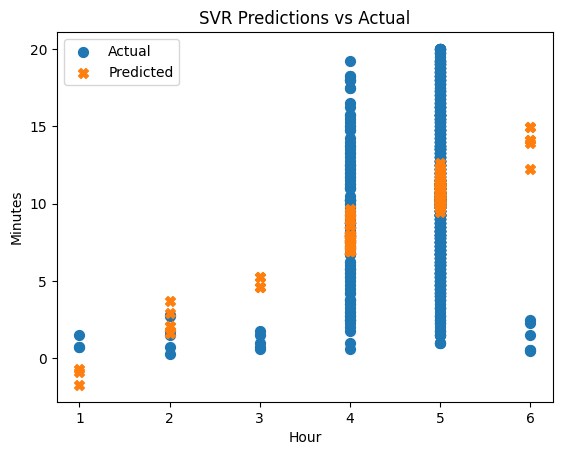

In [82]:
# Make predictions on the test set
y_pred = model.predict(X_test_transformed)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Visualize predictions
plt.scatter(X_test['time_periods'], y_test, label='Actual', s=50)
plt.scatter(X_test['time_periods'], y_pred, label='Predicted', s=50, marker='X')
plt.xlabel('Hour')
plt.ylabel('Minutes')
plt.legend()
plt.title('SVR Predictions vs Actual')
plt.show()

In [60]:
X_test_transformed

array([[15.,  4.,  2.,  1.,  1.,  1.],
       [15.,  4.,  5.,  1.,  1.,  1.],
       [19.,  5.,  3.,  1.,  1.,  1.],
       ...,
       [17.,  5.,  4.,  1.,  1.,  1.],
       [19.,  5.,  3.,  1.,  1.,  1.],
       [15.,  4.,  7.,  1.,  1.,  1.]])

In [61]:
y_pred = model.predict()

TypeError: predict() missing 1 required positional argument: 'X'

In [ ]:
# column_names = ["hr", "day_of_week"]

In [45]:
# pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
# mat = pt.fit_transform(df[column_names])
# mat[:5].round(4)

array([[-2.5206, -0.8958],
       [-2.3658, -0.8958],
       [-1.8505, -0.8958],
       [-1.8505, -0.8958],
       [-1.8505, -0.8958]])

In [46]:
# X= pd.DataFrame(mat, columns=column_names)
# X.head()

,hr,day_of_week
0,-2.520589,-0.895849
1,-2.365781,-0.895849
2,-1.850497,-0.895849
3,-1.850497,-0.895849
4,-1.850497,-0.895849


array([[<Axes: title={'center': 'hr'}>,
        <Axes: title={'center': 'day_of_week'}>]], dtype=object)

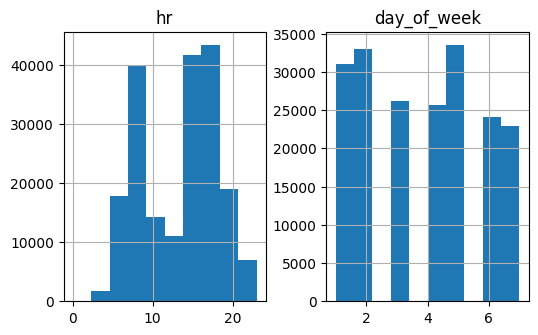

In [47]:
# df[column_names].hist(layout=(1, len(column_names)), figsize=(3*len(column_names), 3.5))